## <font color = 'blue'> Starbucks customer Segmentation</font>

In [ ]:
!pip install -U yellowbrick
!pip install lifetimes

### Data Preview
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

#### portfolio.json

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

### profile.json
* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
* income (float) - customer's income

### transcript.json

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [ ]:
import os
import os
os.chdir('/content/drive/MyDrive/U-udacity/Starbucks_segmentation')

In [ ]:
import pandas as pd
import numpy as np
import json
import math
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
% matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from yellowbrick.cluster.elbow import kelbow_visualizer

from lifetimes.utils import summary_data_from_transaction_data

In [ ]:
# load the json files

portfolio = pd.read_json('data/portfolio.json', orient="records", lines= True)
profile = pd.read_json('data/profile.json', orient='records', lines= True)
transcript = pd.read_json('data/transcript.json', orient='record', lines=True)

### Data Wrangling

#### 1.1 Dataset overview

In [ ]:
print("The shape of portfolio is: ", portfolio.shape)
portfolio.head()

The shape of portfolio is:  (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [ ]:
print("The shape of profile is: ", profile.shape)
profile.head()

The shape of profile is:  (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
print("The shape of transcripts is: ", transcript.shape)
transcript.head()

The shape of transcripts is:  (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### 1.2 Missing values

In [ ]:
# find the columns in profile contains missing values
print("columns with missing value in profile", profile.columns[profile.isnull().mean() != 0] )
# find the columns in transcript contains missing values

print("columns with missing value in transcript", transcript.columns[transcript.isnull().mean() != 0] )
# find the columns in portfolio contains missing values

print("columns with missing value in portfolio", portfolio.columns[portfolio.isnull().mean() != 0] )

columns with missing value in profile Index(['gender', 'income'], dtype='object')
columns with missing value in transcript Index([], dtype='object')
columns with missing value in portfolio Index([], dtype='object')


In [ ]:
# convert dates to Datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

# fill empty genders 
profile['gender'] = profile['gender'].fillna('NA')

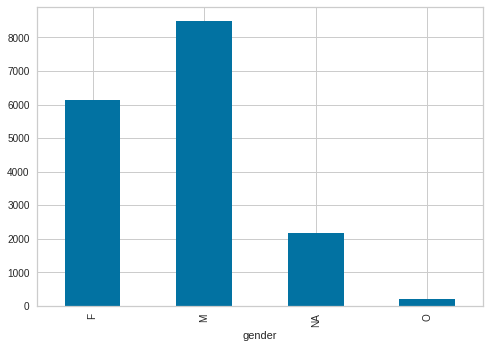

In [ ]:
profile.groupby(['gender']).size().plot(kind = 'bar')

In [ ]:
# find the unique gender

print('unique genders:', profile['gender'].unique() )

print("\nDescriptive stats for age and income:", "\n", profile.describe())

unique genders: ['NA' 'F' 'M' 'O']

Descriptive stats for age and income: 
                 age         income
count  17000.000000   14825.000000
mean      62.531412   65404.991568
std       26.738580   21598.299410
min       18.000000   30000.000000
25%       45.000000   49000.000000
50%       58.000000   64000.000000
75%       73.000000   80000.000000
max      118.000000  120000.000000


In [ ]:
# impute income with mean

profile['income_na'] = profile['income'].isna().astype(int)
profile['income'] = profile['income'].fillna(profile['income'].mean())

#### 1.3 Categories of events and distbribution of time

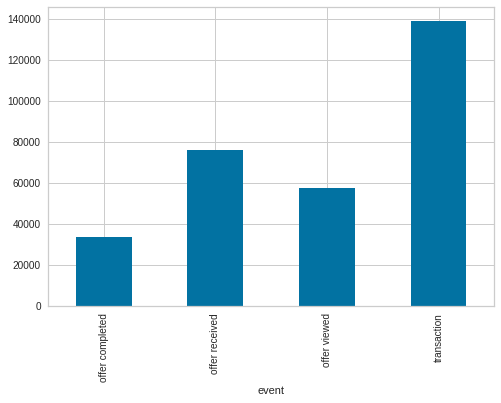

In [ ]:
# Count of different event types

transcript.groupby('event').size().plot(kind = 'bar')

Descriptive stats for time:  
 count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64


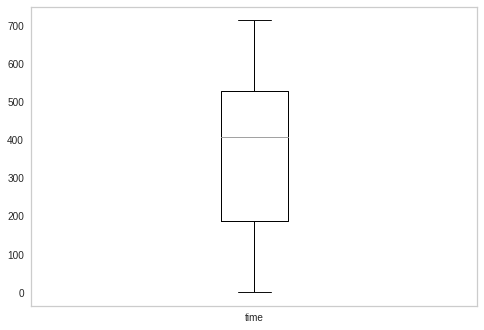

In [ ]:
# Boxplot of the distribution of time
transcript.boxplot(['time'], grid= False)

print("Descriptive stats for time: ", '\n', transcript['time'].describe())

#### 1.4 Outlier

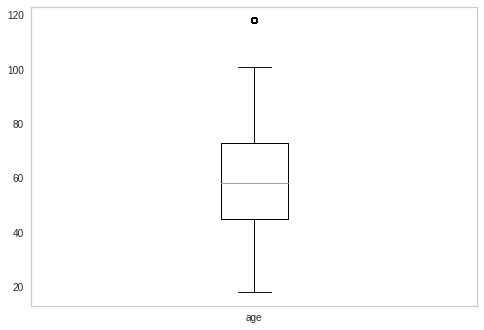

In [ ]:
# Age > 100 
profile.boxplot(['age'], grid= False)
profile = profile.query('age <99')

### Encoding categorical variables

#### 2.1 Encoding channels by MultiLabelBinarizer

In [ ]:
# encoding channels by MultiLabelBinarizer
def encoding(df, col):
  """
  Description: use MultiLabelBinarizer to encoding categorical variables. e.g [email, mobile social] ==> email  mobile social web
                                                                                                          1      1       1     0
  df (dataframe, str): the name of dataframe
  col (str): colname
  """
  mlb = MultiLabelBinarizer()
  dummies = pd.DataFrame(mlb.fit_transform(df[col]), columns= mlb.classes_, index = df.index  )

  return dummies

In [ ]:
mlb = MultiLabelBinarizer()

# create the channel dummies 
channel_dummies = encoding(portfolio, "channels")

# Create the 'offer_type' dummies

offer_type_dummies = portfolio['offer_type'].str.get_dummies()

# concatenate portfolio, channel_dummies and offer_type_dummies
portfolio = pd.concat([portfolio, channel_dummies, offer_type_dummies], axis= 1)

portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


#### 2.2 Get dummies for categorical variables

In [ ]:
# gender type dummies

profile['year_joined'] = profile['became_member_on'].apply(lambda x: str(x.year))

# get gender and year_joined dummies

gender_dummies = profile['gender'].str.get_dummies().add_prefix('gender_')
year_joined_dummies = profile['year_joined'].str.get_dummies().add_prefix('year_joined_')
profile = pd.concat([profile, gender_dummies, year_joined_dummies], axis = 1)
profile.drop(['became_member_on'], axis = 1, inplace= True)
profile.drop(['year_joined'], axis = 1, inplace= True)

In [ ]:
# Event dummies
event_dummies = transcript['event'].str.get_dummies()
event_dummies.drop('transaction', axis = 1, inplace = True)

transcript = pd.concat([transcript, event_dummies], axis = 1 )
transcript.rename(columns={
    'offer completed' : 'offer_completed',
    'offer received' : 'offer_received',
    'offer viewed' : 'offer_viewed'
}, inplace = True)

In [ ]:
transcript.head()

,person,event,value,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0


#### 2.3 Split transcript data frame based on event

In [ ]:
# select the event == transactions

transactions = transcript.query('event == "transaction" ').copy()
transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])

transactions.drop(['value', 'offer_completed', 'offer_received', 'offer_viewed'], axis= 1, inplace= True)


In [ ]:
# select the event == offers

offers = transcript.query('event != "transaction"').copy()
offers['offer_id'] = offers['value'].apply(lambda x: list(x.values()) [0])
offers.drop(['value'], axis = 1, inplace= True)

#### 2.4 Merge offers and transaction with customer profile
* merge the offers dataframe with profile and portfolio
* make a new transaction dataframe by merge with profile


In [ ]:
# merge offers with profile

offers = offers.merge(profile, left_on= "person", right_on= 'id')

offers = offers.merge(portfolio, left_on= 'offer_id', right_on= 'id')
offers.drop(['id_x', 'id_y'], axis= 1, inplace= True)
offers.set_index('offer_id', inplace= True)

In [ ]:
# Merge Transaction with profile

transactions  =  transactions.merge(profile, left_on= 'person', right_on='id')
transactions.drop(['event'], axis = 1, inplace= True)

In [ ]:
transactions.head(2)

,person,time,amount,gender,age,id,income,income_na,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,20,02c083884c7d45b39cc68e1314fec56c,30000.0,0,1,0,0,0,0,0,1,0,0
1,02c083884c7d45b39cc68e1314fec56c,6,1.44,F,20,02c083884c7d45b39cc68e1314fec56c,30000.0,0,1,0,0,0,0,0,1,0,0


#### 2.5 offers procedures from receive -> reviewed -> completed, calculate the time spent for each step

In [ ]:
offers.reset_index(inplace= True)

offers[offers.duplicated(subset= ['offer_id', 'person'], keep = False)].head()

,offer_id,person,event,time,offer_completed,offer_received,offer_viewed,gender,age,income,income_na,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,reward,channels,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,F,75,100000.0,0,1,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,F,75,100000.0,0,1,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,1,0,0,F,75,100000.0,0,1,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer received,408,0,1,0,M,68,70000.0,0,0,1,0,0,0,0,0,0,1,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer viewed,420,0,0,1,M,68,70000.0,0,0,1,0,0,0,0,0,0,1,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0


In [ ]:
# calculate the time spent for each step

offers['time'] = offers['time'] + 0.5
offers['received_time'] = offers['offer_received'] * offers['time']
offers['viewed_time'] = offers['offer_viewed'] * offers['time']
offers['completed_time'] = offers['offer_completed'] * offers['time']


#### 2.6 Offer can be received multiple times by the same person, use the first time received, also keep track of the number of exposures

In [ ]:
# get the first time and totol number of exposures

offers_mins = offers.groupby(['person', 'offer_id', 'event']).min()
offers_sum = offers.groupby(['person', 'offer_id', 'event'])[['offer_received', 'offer_viewed', 'offer_completed']].sum()

# update the offer_receive, offer_viewed and offer_completed with the sum of event for each person
offers_mins.update(offers_sum)


offers_grouped = offers_mins.groupby(['person', 'offer_id']).max().reset_index()
offers_grouped.fillna(0, inplace= True)
offers_grouped.head()

,person,offer_id,time,offer_completed,offer_received,offer_viewed,gender,age,income,income_na,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,reward,channels,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.5,1,1,0,M,33,72000.0,0,0,1,0,0,0,0,0,1,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1,0,1,0,576.5,0.0,576.5
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,1,0,0,"[web, email, mobile]",0,4,informational,1,1,0,1,0,0,1,336.5,372.5,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,1,0,0,"[email, mobile, social]",0,3,informational,1,1,1,0,0,0,1,168.5,192.5,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.5,1,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,1,0,5,"[web, email, mobile, social]",5,5,bogo,1,1,1,1,1,0,0,408.5,456.5,414.5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540.5,1,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,1,0,2,"[web, email, mobile, social]",10,10,discount,1,1,1,1,0,1,0,504.5,540.5,528.5


#### 2.7 Some missatrributions
1. duration is not consistent with received_time, `end_time = received_time + duraction *24`
2. view_time < end_time is not correct ==> viewed_ontime
3. completed_time < end_time  ==> completed_ontime
4. some misattribution like completion without view, completion before view, or view before receipt

In [ ]:
offers_grouped['end_time'] = offers_grouped['received_time'] + offers_grouped['duration']*24
offers_grouped['viewed_on_time'] = offers_grouped.apply(lambda x: 1 if x['viewed_time'] < x['end_time'] and x['viewed_time'] != 0 else 0, axis = 1)

offers_grouped['completed_on_time'] = offers_grouped.apply(lambda x: 1 if x['completed_time'] < x['end_time'] and x['completed_time'] != 0 else 0, axis = 1 )

In [ ]:
# dropping misattributions 
offers_grouped = offers_grouped.query('~(completed_time > 0 and viewed_time == 0)')

offers_grouped = offers_grouped.query('~(completed_time != 0 and completed_time < viewed_time)')
offers_grouped = offers_grouped.query('~(viewed_time != 0 and viewed_time < received_time)')

#### 2.8 Calculate the Frequency and Recency
1. calculate Recency and Frequency by `summary_data_from_transaction_data`
2. profile dataframe join with recency and frequency

In [ ]:
# convert datetime
transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours = x))

# calculate recency and frequency
rf = summary_data_from_transaction_data(transactions, 'person', 'datetime', monetary_value_col='amount')
rf.drop('T', axis = 1, inplace= True)

# transaction merge with frequency and recenty
profile.rename({'id' : 'person'}, axis = 1, inplace= True)
profile.set_index('person', inplace= True)
customers = profile.join(rf)
customers.head()

,gender,age,income,income_na,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,frequency,recency,monetary_value
person,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,0,1,0,0,0,0,0,0,1,0,2.0,21.0,27.750000
78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,0,1,0,0,0,0,0,0,1,0,5.0,16.0,24.320000
e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,0,1,0,0,0,0,0,0,1,1.0,10.0,18.420000
389bc3fa690240e798340f5a15918d5c,M,65,53000.0,0,0,1,0,0,0,0,0,0,1,2.0,22.0,13.445000
2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,0,0,1,0,0,0,0,0,1,0,3.0,15.0,4.433333


#### 2.9 Calculate view rate and conversion rate by different category of offers, like BOGO, discount and All offer

- BOGO
- discount
- All

In [ ]:
def sum_greater_than_zero(x):
  """
  Description: count non-zero items
  x:  (pd.series)
  return: numeric of sum
  """
  return (x >0).sum()

def mean_greater_than_zero(x):
  """
  Description: calculate the mean of >0 items
  X: pd.series
  return: numeric mean value
  """
  return x.replace(0, np.nan).mean()

In [ ]:
def view_complete_rate(df, received, viewed, completed):
  """
  Desc: Calculate the view rate and completion rate
  df: Dataframe
  received,viewed, completed (Str): the name of column, like "offers_viewed_cnt"
  return: dataframe
  """
  df['vr'] = df[viewed]/df[received]
  df['cr'] = df[completed]/df[viewed]

  df.drop([received, viewed, completed], axis = 1, inplace = True)

  return df

In [ ]:
def performance_cnt(df, offer_type):
  """
  Description: get three columns returning offer_recieved_cnt, viewed_cnt and completed_cnt
  df: dataFrame
  offer_type (str): e.g "BOGO"
  return: dataframe
  """
  performance = df.query('offer_type == offer_type').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
  return performance

In [ ]:
# count the number offers received, viewed and completed within BOGO 
bogo_performance = offers_grouped.query('offer_type == "bogo" ').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero), 
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero)
)

In [ ]:
# bogo performance by view rate

bogo_performance['bogo_vr'] = bogo_performance['offers_viewed_cnt']/bogo_performance['offers_received_cnt']

# bogo performance by completion rate
bogo_performance['bogo_cr'] = bogo_performance['offers_completed_cnt']/bogo_performance['offers_viewed_cnt']

# drop columns
bogo_performance.drop(['offers_received_cnt', 'offers_viewed_cnt', 'offers_completed_cnt'], axis= 1, inplace= True)

In [ ]:
# count the number offers received, viewed and completed within discount offers

discount_performance = offers_grouped.query('offer_type == "discount" ').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero), 
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero)
)

In [ ]:
# the vr, cr for discount performance

discount_performance  = view_complete_rate(discount_performance, "offers_received_cnt", "offers_viewed_cnt", "offers_completed_cnt" )

discount_performance = discount_performance.rename(columns=({'vr':'discount_vr', 'cr': 'discount_cr'}))

In [ ]:
# The performance of informational
informational_performance = offers_grouped.query('offer_type == "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)

# vr cr for informational 
informational_performance = view_complete_rate(informational_performance, "offers_received_cnt", "offers_viewed_cnt", "offers_completed_cnt" )

informational_performance = informational_performance.rename(columns=({'vr':'informational_vr', 'cr': 'informational_cr'}) )


In [ ]:
# All offers conversion rate

total_performance = offers_grouped.query('offer_type != "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)

# vr, cr for all offers
total_performance = view_complete_rate(total_performance, "offers_received_cnt", "offers_viewed_cnt", "offers_completed_cnt" )

total_performance = total_performance.rename(columns=({'vr':'total_vr', 'cr': 'total_cr'}) )

#### 2.10 Combine the customer's information with their performance under different offer categories 

In [ ]:
# combine customer and other performance dataframes in 2.9

customers = customers.join(bogo_performance).join(discount_performance).join(informational_performance).join(total_performance)

customers.fillna(0, inplace= True)

In [ ]:
customers.head()

,gender,age,income,income_na,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,frequency,recency,monetary_value,bogo_vr,bogo_cr,discount_vr,discount_cr,informational_vr,informational_cr,total_vr,total_cr
person,,,,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,0,1,0,0,0,0,0,0,1,0,2.0,21.0,27.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,0,1,0,0,0,0,0,0,1,0,5.0,16.0,24.320000,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.000000
e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,0,1,0,0,0,0,0,0,1,1.0,10.0,18.420000,1.0,1.0,1.0,0.5,0.0,0.0,1.0,0.666667
389bc3fa690240e798340f5a15918d5c,M,65,53000.0,0,0,1,0,0,0,0,0,0,1,2.0,22.0,13.445000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.000000
2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,0,0,1,0,0,0,0,0,1,0,3.0,15.0,4.433333,0.0,0.0,1.0,0.5,0.0,0.0,1.0,0.500000


In [ ]:
offers_grouped.head()

,person,offer_id,time,offer_completed,offer_received,offer_viewed,gender,age,income,income_na,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,reward,channels,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time,end_time,viewed_on_time,completed_on_time
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,1,0,0,"[web, email, mobile]",0,4,informational,1,1,0,1,0,0,1,336.5,372.5,0.0,432.5,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,1,0,0,"[email, mobile, social]",0,3,informational,1,1,1,0,0,0,1,168.5,192.5,0.0,240.5,1,0
5,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576.5,1,1,1,O,40,57000.0,0,0,0,1,0,0,0,0,0,1,5,"[web, email]",20,10,discount,1,0,0,1,0,1,0,408.5,432.5,576.5,648.5,1,1
6,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252.5,1,1,1,O,40,57000.0,0,0,0,1,0,0,0,0,0,1,3,"[web, email, mobile, social]",7,7,discount,1,1,1,1,0,1,0,168.5,186.5,252.5,336.5,1,1
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,6.5,0,1,1,O,40,57000.0,0,0,0,1,0,0,0,0,0,1,0,"[web, email, mobile]",0,4,informational,1,1,0,1,0,0,1,0.5,6.5,0.0,96.5,1,0


#### 2.11 Calculate metric for customer offers

In [ ]:
# calculate some metrics for the offers
customer_offers = offers_grouped.groupby('person').agg(
    reward_avg = ('reward', 'mean'),
    difficulty_avg = ('difficulty', 'mean'),
    email_cnt = ('email', 'sum'),
    mobile_cnt = ('mobile', 'sum'),
    social_cnt = ('social', 'sum'),
    web_cnt = ('web', 'sum'),
    bogo_cnt = ('bogo', 'sum'),
    discount_cnt = ('discount', 'sum'),
    informational_cnt = ('informational', 'sum'),
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
    exposures_received_avg = ('offer_received', 'mean'),
    exposures_viewed_avg = ('offer_viewed', 'mean'),
    exposures_completed_avg = ('offer_completed', 'mean')
)

In [ ]:
# combine metrics with customer profiles

customers = customers.join(customer_offers)


customers.drop(['gender', 'income_na'], axis = 1, inplace= True)
customers.dropna(inplace = True)

### Data Exploratory Analysis

#### 3.1 Explore the distribution of gender and the relationship with other demographic information

- The distribution of gender
- The relationship between income, amount 

Text(0.5, 1.0, 'Gender Distribution')

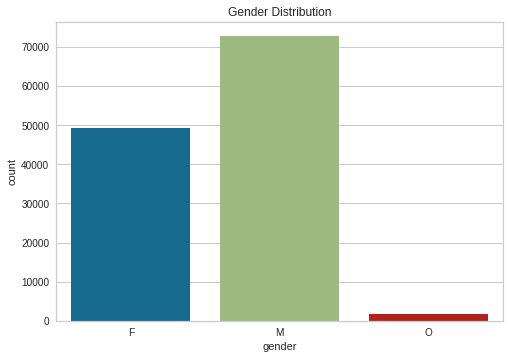

In [ ]:
df = transactions[['gender', 'age', 'amount', 'income']]

ax = sns.countplot(x = 'gender', data = df)
ax.set_title("Gender Distribution")


In [ ]:
df = df.query('gender in ["F", "M"]')
df.rename(columns={'gender': "Gender"}, inplace = True)
df['Gender'] = df['Gender'].map({'M': 'Male', 'F': 'Female'})

Text(0.5, 1.05, 'Age, Income and Spending by Gender')

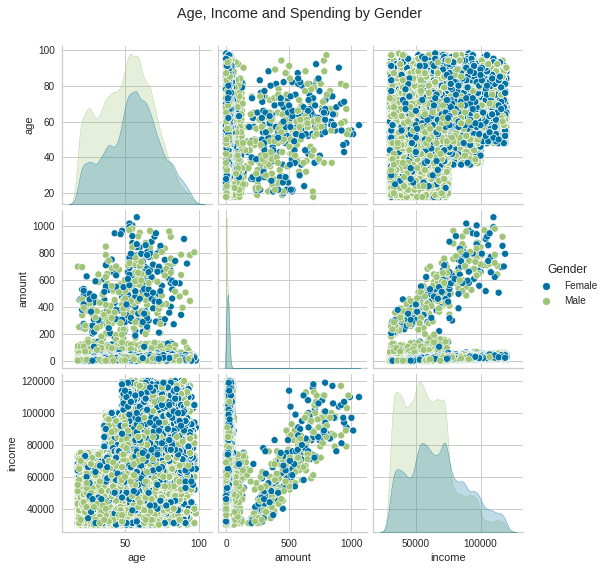

In [ ]:
g = sns.pairplot(df, hue = 'Gender')
g.fig.suptitle('Age, Income and Spending by Gender', y = 1.05)

In [ ]:
df = offers.groupby(['event', 'offer_type'])['person'].size().reset_index()
df['event'] = pd.Categorical(df['event'], ['offer received', 'offer viewed', 'offer completed'])

df['event'] = df['event'].map({"offer received": "Received",
                               'offer viewed': 'Viewed',
                               'offer completed': 'Completed'})

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Informational')]

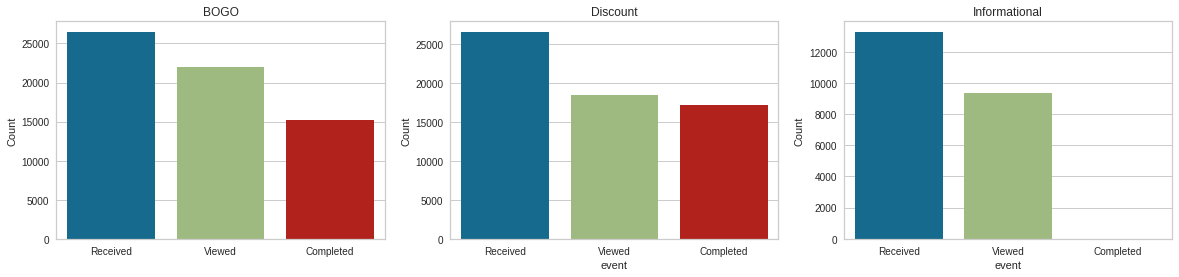

In [ ]:
fig, axs = plt.subplots(ncols= 3, figsize = (20, 4))

# the funnel of BOGO
ax = sns.barplot('event', y = 'person', data = df.query('offer_type == "bogo" '), ax = axs[0])
ax.set(xlabel='', ylabel='Count', title = 'BOGO')

# the funnel of discount
ax = sns.barplot('event', y = 'person', data = df.query('offer_type == "discount"'), ax = axs[1])
ax.set(ylabel='Count', title = 'Discount')

# the funnel of Informational
ax = sns.barplot('event', y = 'person', data = df.query('offer_type == "informational" '), ax = axs[2])
ax.set(ylabel = 'Count', title = 'Informational')

### Modeling by Unsupervised Clustering

####3.1 Feature Scaling: use the standard scaler to standardize features

In [ ]:
scaler = StandardScaler().fit(customers)
customers_scaled = scaler.transform(customers)

# check the standard scaled numpy array follow (mu, 1)
customers_scaled.std(axis = 0)[0:5], customers_scaled.mean(axis = 0)[:5]

(array([1., 1., 1., 1., 1.]),
 array([ 1.77430492e-17,  1.41944394e-16, -1.25529056e-17, -8.20766903e-17,
        -9.65608121e-18]))

#### 3.2 Dimensional Reduction with PCA

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(customers_scaled)

In [ ]:
# visualize the plot of principle components

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

Text(0.5, 1.0, 'Explained variance with principle components')

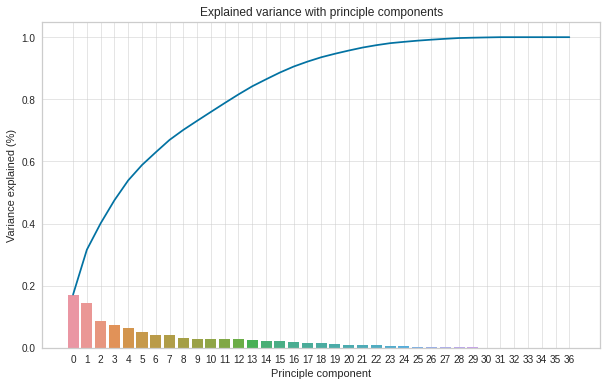

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.barplot(ind, vals)
ax2 = sns.lineplot(ind, cumvals)

ax.grid(b = True, which = 'major', linewidth = 0.5)

ax.set_xlabel('Principle component')
ax.set_ylabel('Variance explained (%)')
plt.title('Explained variance with principle components')

In [ ]:
# get the components that could explain 80% of variance

num_components = len(cumvals[cumvals < 0.8]) 

# Rerun PCA with components that explain 80% variance
pca = PCA(num_components).fit(customers_scaled)

# variance and covariance matrix
X_pca = pca.transform(customers_scaled)

# convert np matrix to pandas dataframe
X_pca = pd.DataFrame(X_pca)

#### 3.3 Unsupervised Clustering By several Methods
- identify cluster number by elbow method
- K-means, DBSCAN and OPTICS clustering
- Model evaluation 

##### 3.3.1 elbow method to identy cluster number

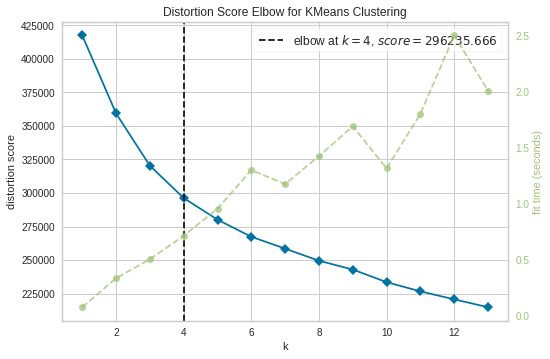

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f72c570c7d0>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=13,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

In [ ]:
kelbow_visualizer(KMeans(), X_pca, k= (1,14))

##### 3.3.2 K-Means clustering

In [ ]:
model = KMeans(n_clusters= 4, random_state=28).fit(X_pca)
kmeans_clusters = model.predict(X_pca)

In [ ]:
# visulize K-mean clustering

df = X_pca.copy()
df['Cluster'] = kmeans_clusters

sns.scatterplot(df.iloc[:,0], df.iloc[:,1], hue = df['Cluster'], palette='Set1', s= 50)

##### 3.3.3 DBSCAN clustering

Text(0.5, 1.0, 'Distances')

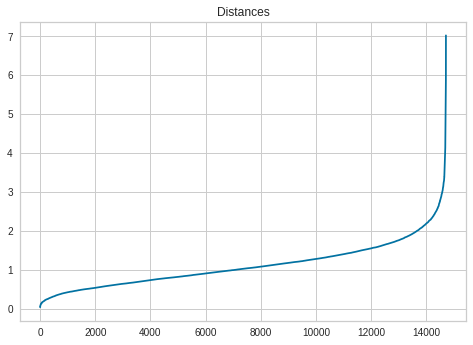

In [ ]:
# calculate the neighborhood distance

neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

distances = np.sort(distances, axis = 0)
distances = distances[:, 1]
plt.plot(distances)
plt.title('Distances')

In [ ]:
# DBSCAN model and visualization

model = DBSCAN(eps= 2.5, min_samples= 150)
dbscan_clusters = model.fit_predict(X_pca)

print('Number of clusters: ', len(np.unique(dbscan_clusters)))
df = X_pca.copy()
df['Cluster'] = dbscan_clusters

# visualization
sns.scatterplot(df.iloc[:, 0], df.iloc[:, 1], hue = df['Cluster'], palette='Set1', s = 50).set_title('Visualization of DESCAN clustering')

##### 3.3.4 OPTICS clustering

In [ ]:
model = OPTICS(min_samples=40)
optics_clustering = model.fit_predict(X_pca)

print('Number of clusters: ', len(np.unique(optics_clustering)))

Number of clusters:  3


Text(0.5, 1.0, 'Visualization of OPTICS clustering')

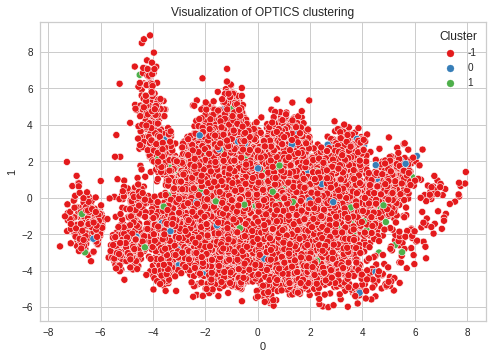

In [ ]:
df = X_pca.copy()
df['Cluster'] = optics_clustering
sns.scatterplot(df.iloc[:, 0], df.iloc[:, 1], hue = df['Cluster'], palette='Set1', s = 50).set_title('Visualization of OPTICS clustering')

#### Evaluation

1. Evaluate OPTICS 

In [ ]:
df = customers.copy().reset_index()
df['Cluster'] = optics_clustering
df = df.melt(id_vars=['person', 'Cluster'])
# the percentage of cluster == -1 
print("The percentage of customer without clustering under OPTICS method:", round(df.query('Cluster == -1').shape[0] *100/df.shape[0],2),"%" )

The percentage of customer without clustering under OPTICS method: 96.81 %


2. Evaluate DBSCAN

In [ ]:
df = customers.copy().reset_index()
df['Cluster'] = dbscan_clusters
df = df.melt(id_vars=['person', 'Cluster'])

# the percentage without cluster assignment with DBSCAN model
print("The percentage of customer without clustering under DBSCAN method:", round(df.query('Cluster == -1').shape[0] *100/df.shape[0],2),"%" )

The percentage of customer without clustering under DBSCAN method: 78.29 %


3. Evaluate K-Means

In [ ]:
df = customers.copy().reset_index()
df['Cluster'] = kmeans_clusters
df = df.melt(id_vars=['person', 'Cluster'])

# the percentage without cluster assignment with DBSCAN model
print("The percentage of customer without clustering under K-Means method:", round(df.query('Cluster == -1').shape[0] *100/df.shape[0],2),"%" )
df = df.query('Cluster != -1').groupby(['Cluster', 'variable']).mean().reset_index()
df = df[~ df.variable.isin (['informational_cr', 'total_vr' ]) ]

The percentage of customer without clustering under K-Means method: 0.0 %


### Customer segmentation and business implication

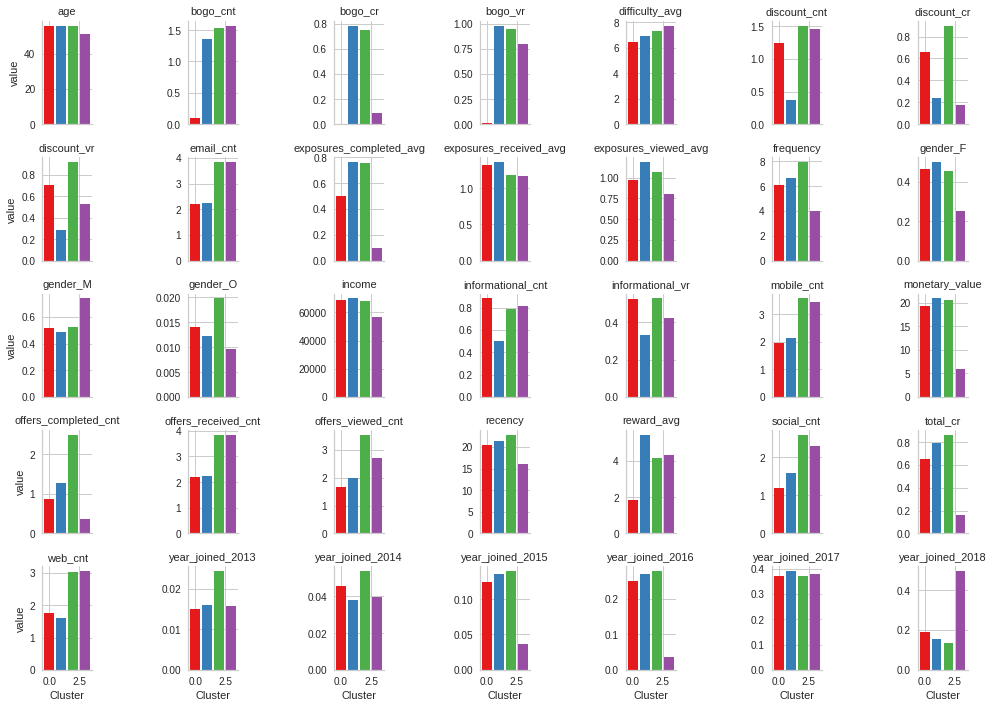

In [ ]:
g = sns.FacetGrid(df, col='variable', hue='Cluster', palette='Set1', col_wrap=7, height=2, sharey=False)
g = g.map(plt.bar, 'Cluster', 'value').set_titles("{col_name}");

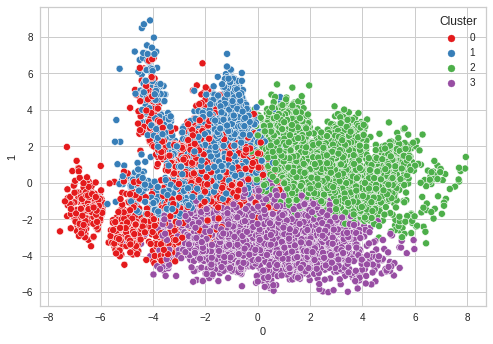

In [ ]:
df = X_pca.copy()
df['Cluster'] = kmeans_clusters

sns.scatterplot(df.iloc[:,0], df.iloc[:,1], hue = df['Cluster'], palette='Set1', s= 50)

Text(0.5, 1.0, 'Customer by Cluster')

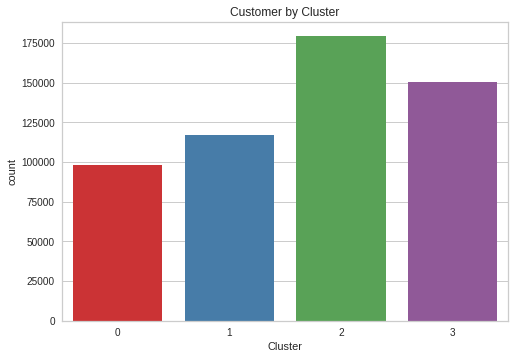

In [ ]:
# plot total number of customers per cluster

df = customers.copy().reset_index()
df['Cluster'] = kmeans_clusters

df = df.melt(id_vars= ['person', 'Cluster'])

ax = sns.countplot(x= 'Cluster', data= df, palette='Set1')
ax.set_title('Customer by Cluster')

- Segment 1 (Red): Mean Age: 56, bogo_cr: 0, discount_cr:0.66, exposures_completed: 0.50,  income ~ 69k, recency: 20.45, mainly joined in 2016 and 2017, received very few BOGO offers. discount completion rate (0.66), exposures completion rate (0.50), most of them joined before 2018, total completion rate (0.65). 

- Seqment 2 (blue): Age : 56, mean income: 70k, total completion rate: 0.79.  BOGO completion rate (0.78), discount cr(0.23), exposure completed(0.76) Female > Male, prefer mobile > web > social, year joined Y2Y increase from 2013-2017, decrease in 2018. This group received regular BOGO, but few discount offers, BOGO converted pretty well

- Segment 3 (green): Age: 55, average income: ~68K, Male > Female, total completion rate(0.86), bogo_cr(0.75), discount_cr(0.9), channel: mobile > web > social. Join the year, Y2Y joined number increased from 2013-2017, but trend changed direction in 2018. A main group for targeting with discount offers

- segment 4 (Purple): Age: 50, average income ~57K, Male >> Female, total completion rate: 0.16. BOGO_cr (0.09), discount_cr(0.17), recency ~ 15, lowest, most joined in 2017-2018, and the Y2Y still increase, channel: email > mobile > web > social 